In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Path_Project = "/content/gdrive/My Drive/14. Low-carbon H2"
Path_Data = Path_Project + "/Data"
Path_Modeling = Path_Project + "/Modeling"
Path_Graph = Path_Project + "/Graph"

Mounted at /content/gdrive


# 데이터 불러오기

In [3]:
import pandas as pd

Path_project = '/content/gdrive/My Drive/Project/Textbook'

data_smr = pd.read_csv(f'{Path_project}/Data/Data for textbook_SMR.csv', header=0)

In [4]:
data_smr.head()

#그림 1

,NG feed,NG fuel,Water,Air,PSA recovery,H2,Efficiency
0,38.07504,1.192972,128.988119,268.8,85,146.0,81.2
1,38.07504,1.192972,128.988119,268.8,83,142.6,79.3
2,38.07504,1.192972,128.988119,268.8,81,139.2,77.4
3,38.07504,1.192972,128.988119,268.8,79,135.7,75.4
4,38.07504,1.192972,128.988119,268.8,77,132.3,73.5


In [5]:
data_smr.info()

#그림 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71680 entries, 0 to 71679
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NG feed       71680 non-null  float64
 1   NG fuel       71680 non-null  float64
 2   Water         71680 non-null  float64
 3   Air           71680 non-null  float64
 4   PSA recovery  71680 non-null  int64  
 5   H2            71680 non-null  float64
 6   Efficiency    71680 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 3.8 MB


In [6]:
data_smr.describe()

#그림 3

,NG feed,NG fuel,Water,Air,PSA recovery,H2,Efficiency
count,71680.000000,71680.000000,71680.000000,71680.000000,71680.000000,71680.000000,71680.000000
mean,41.983290,1.314562,141.598690,297.920000,78.000000,147.247344,74.305312
std,2.494594,0.079600,8.255614,18.059583,4.582608,10.856272,4.763979
min,38.075040,1.192972,128.988119,268.800000,71.000000,122.000000,63.500000
25%,39.812040,1.253767,135.293405,282.240000,74.500000,139.175000,70.500000
50%,41.983290,1.314562,141.598690,297.920000,78.000000,146.950000,74.300000
75%,44.154540,1.375357,147.903975,313.600000,81.500000,155.025000,78.100000
max,45.891540,1.436152,154.209260,327.040000,85.000000,175.500000,85.500000


# 인공신경망 모델링

## 훈련/평가 데이터

In [7]:
from sklearn.model_selection import train_test_split

test_ratio = 0.3
random_state = 42
data_train, data_test = train_test_split(data_smr, test_size = test_ratio,
                                         shuffle=True,
                                         random_state=random_state)

## 모델 셋팅

In [8]:
from sklearn.preprocessing import StandardScaler

var_x = ["NG feed", "NG fuel", "Water", "Air", "PSA recovery"]
var_y = ["H2"]

scaler_x = StandardScaler()
scaler_y = StandardScaler()

train_x = scaler_x.fit_transform(data_train[var_x])
train_y = scaler_y.fit_transform(data_train[var_y])

test_x = scaler_x.transform(data_test[var_x])
test_y = scaler_y.transform(data_test[var_y])

In [9]:
from tensorflow import keras
from tensorflow.keras.layers import *

def NeuralNet(num_x, num_y, num_layers, num_neurons, learning_rate):
    model = keras.Sequential()
    model.add(Dense(num_neurons, 
                    activation="relu", 
                    input_shape=[num_x]))
    for n in range(num_layers-1):
        model.add(Dense(num_neurons,
                        activation="relu"))
    model.add(Dense(num_y))

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate, 
                                      beta_1=0.9, beta_2=0.999)
    model.compile(loss='mse',
                  optimizer = optimizer)
    return model

In [10]:
num_x = len(var_x)
num_y = len(var_y)
num_layers = 5
num_neurons = 20
learning_rate = 0.001

nn_model = NeuralNet(num_x, num_y, num_layers, num_neurons, learning_rate)

## 모델 학습/저장/불러오기

In [88]:
# 모델 학습 셋팅
training_epoch = 1000
patience = 20
early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience,
                                                  restore_best_weights= True,
                                                  monitor='val_loss')

# 모델 저장 경로 설정
import os

def CreateFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

path_save = f'{Path_project}/Model'
model_name = 'nn_model'
CreateFolder(path_save)

# 모델 학습
if not os.path.exists(f"{path_save}/{model_name}"):
    history = nn_model.fit(train_x, train_y,
                       epochs = training_epoch, callbacks=[early_stopping_cb],
                       verbose = 2,
                       validation_data=(test_x, test_y))
# 모델 저장
    nn_model.save(f'{path_save}/{model_name}')

# 모델 불러오기
else:
    nn_model = keras.models.load_model(f"{path_save}/{model_name}")

## 모델 평가

In [12]:
import numpy as np

def R_Squared(prediction, actual):    
    actual_mean = np.mean(actual, axis=0)
    SSR = np.sum( (prediction - actual)**2 , axis=0)    
    RSS = np.sum( (prediction - actual_mean )**2, axis=0 )
    TSS = np.sum( (actual - actual_mean )**2, axis=0 )    
    r2 = 1 - SSR/TSS

    return r2
    
def RMSE(prediction, actual):
    rmse = np.sqrt(np.mean((prediction - actual)**2, axis=0))

    return rmse

In [13]:
prediction = pd.DataFrame(scaler_y.inverse_transform(nn_model.predict(test_x)),
                       index=data_test.index,
                       columns=var_y)
actual_value = data_test[var_y]

r2 = R_Squared(prediction, actual_value)
rmse = RMSE(prediction, actual_value)

display(pd.DataFrame([r2, rmse],
                     index=["R2", "RMSE"]))

,H2
R2,0.999995
RMSE,0.024163


Text(0, 0.5, 'Actual value')

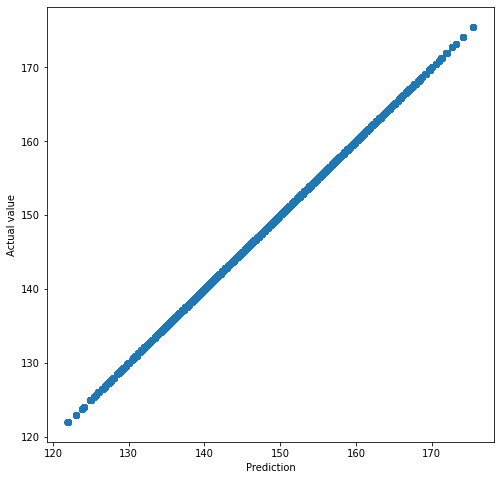

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(prediction, actual_value)
plt.xlabel("Prediction")
plt.ylabel("Actual value")

# 모델 민감도 분석

In [89]:
# Generate X Cases by sensitivity rate
def SensitivityAnalysis(x_base, sensitivity_points, nn_model, var_x, var_y, scaler_x, scaler_y):
    # Generate X points to analyze
    list_x_points = [
                    np.linspace(
                        (1 - 0.01*sensitivity_points) * x_base[x],
                        (1 + 0.01*sensitivity_points) * x_base[x],
                        sensitivity_points
                    ) for x in var_x 
    ]

    base_df = x_base.to_frame().transpose()
    x_cases = base_df.copy()

    for x, x_points in zip(var_x, list_x_points):
        for x_value in x_points:
            x_case = base_df.copy()
            x_case[x] = x_value
            x_cases = x_cases.append(x_case)

    x_cases = x_cases.reset_index(drop=True)

    # Calculate Y for X cases
    y_cases = scaler_y.inverse_transform(nn_model.predict(scaler_x.transform(x_cases)))

    x_df = pd.DataFrame(x_cases, columns=var_x)
    y_df = pd.DataFrame(y_cases, columns=var_y)
    xy_df = pd.concat([x_df, y_df], axis=1)

    xy_base = xy_df.loc[0]

    for y in var_y:
        print(f"Sensitivity analysis of variable {y}")
        plt.figure(figsize=(9*len(var_x), 9))

        for i, x in enumerate(var_x):
            plt.subplot(1, len(var_x), i+1)
            range_plot = np.arange(i*sensitivity_points+1,(i+1)*sensitivity_points+1)
            x_plot = xy_df[x].loc[range_plot]
            y_plot = xy_df[y].loc[range_plot]

            plt.plot(x_plot, y_plot, 'b', linewidth=2)
            plt.plot([x_plot.iloc[0], x_plot.iloc[sensitivity_points-1]], [y_plot.iloc[int((sensitivity_points-1)/2)], y_plot.iloc[int((sensitivity_points-1)/2)]], 'r--')
            plt.scatter(x_plot, y_plot, s=20, alpha=0.5, color='b', marker='o')

            plt.title(x, **{'size':24}) 
            plt.xticks(**{'size':14})
            plt.yticks(**{'size':14})       

        plt.tight_layout()
        plt.show()

    for y in var_y:
        print(f"Sensitivity analysis of variable {y} (%)")
        plt.figure(figsize=(9*len(var_x), 9))
        
        for i, x in enumerate(var_x):
            plt.subplot(1, len(var_x), i+1)
            idx_min = i*sensitivity_points+1
            idx_max = (i+1)*sensitivity_points+1
            range_plot = np.arange(idx_min,idx_max)

            x_plot = xy_df[x].loc[range_plot]
            y_plot = xy_df[y].loc[range_plot]

            x_plot = (xy_df[x].loc[range_plot] - (x_plot.iloc[0] + x_plot.iloc[sensitivity_points-1])/2)/xy_df[x].loc[range_plot]*100
            y_plot = (xy_df[y].loc[range_plot] - y_plot.iloc[int((sensitivity_points-1)/2)])/xy_df[y].loc[range_plot]*100

            plt.plot(x_plot, y_plot, 'b', linewidth=2)
            plt.plot([x_plot.iloc[0], x_plot.iloc[sensitivity_points-1]], [y_plot.iloc[int((sensitivity_points-1)/2)], y_plot.iloc[int((sensitivity_points-1)/2)]], 'r--')
            plt.scatter(x_plot, y_plot, s=20, alpha=0.5, color='b', marker='o')

            plt.title(x, **{'size':30}) 
            plt.xticks(**{'size':30})
            plt.yticks(**{'size':30})       

        plt.tight_layout()
        plt.show()

    return xy_df

Sensitivity analysis of variable H2


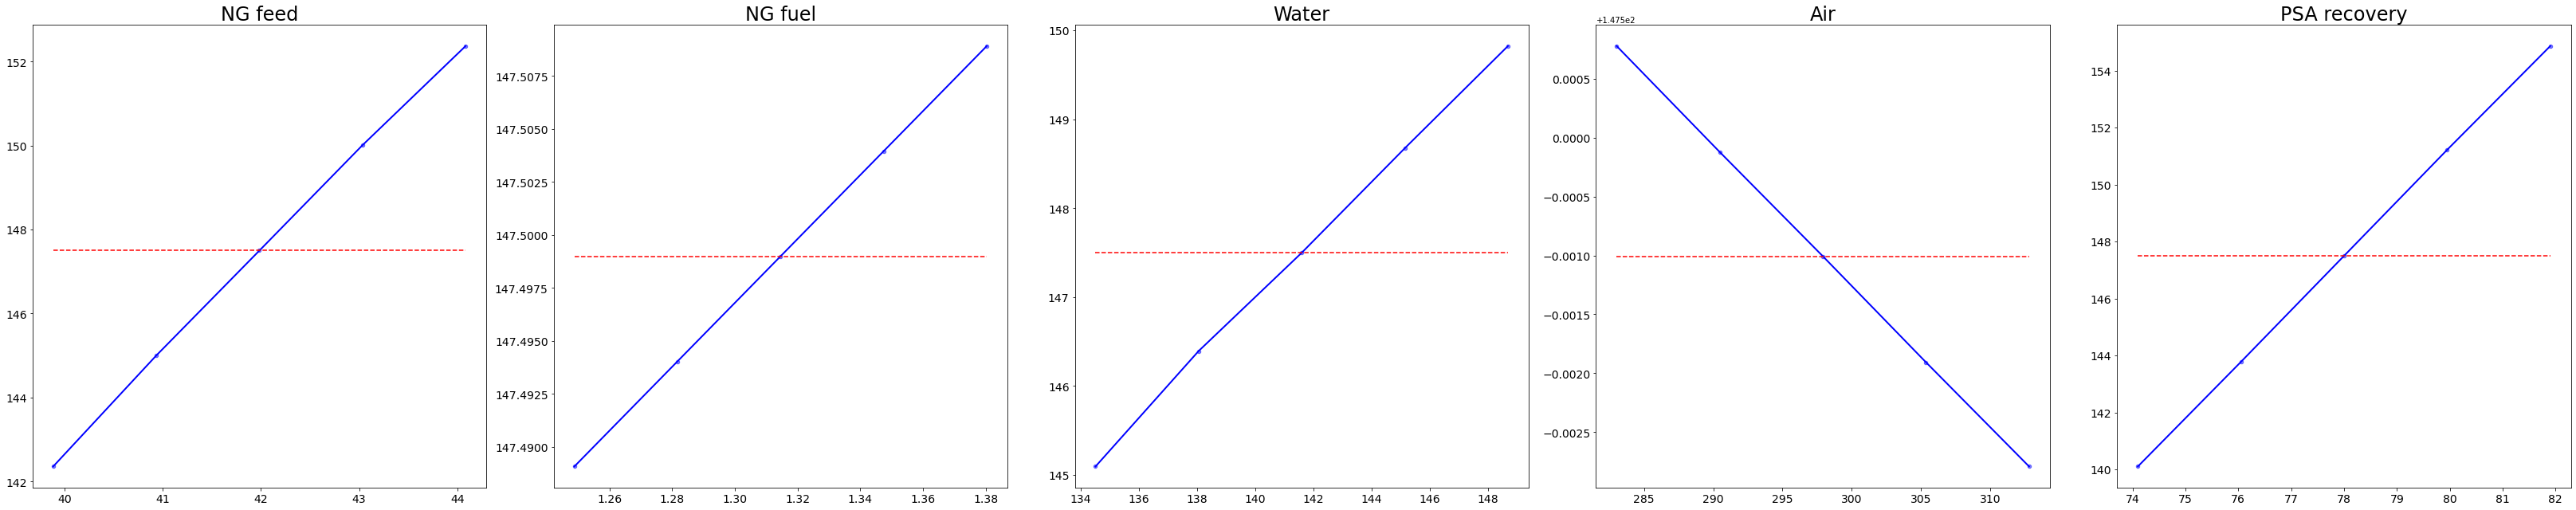

Sensitivity analysis of variable H2 (%)


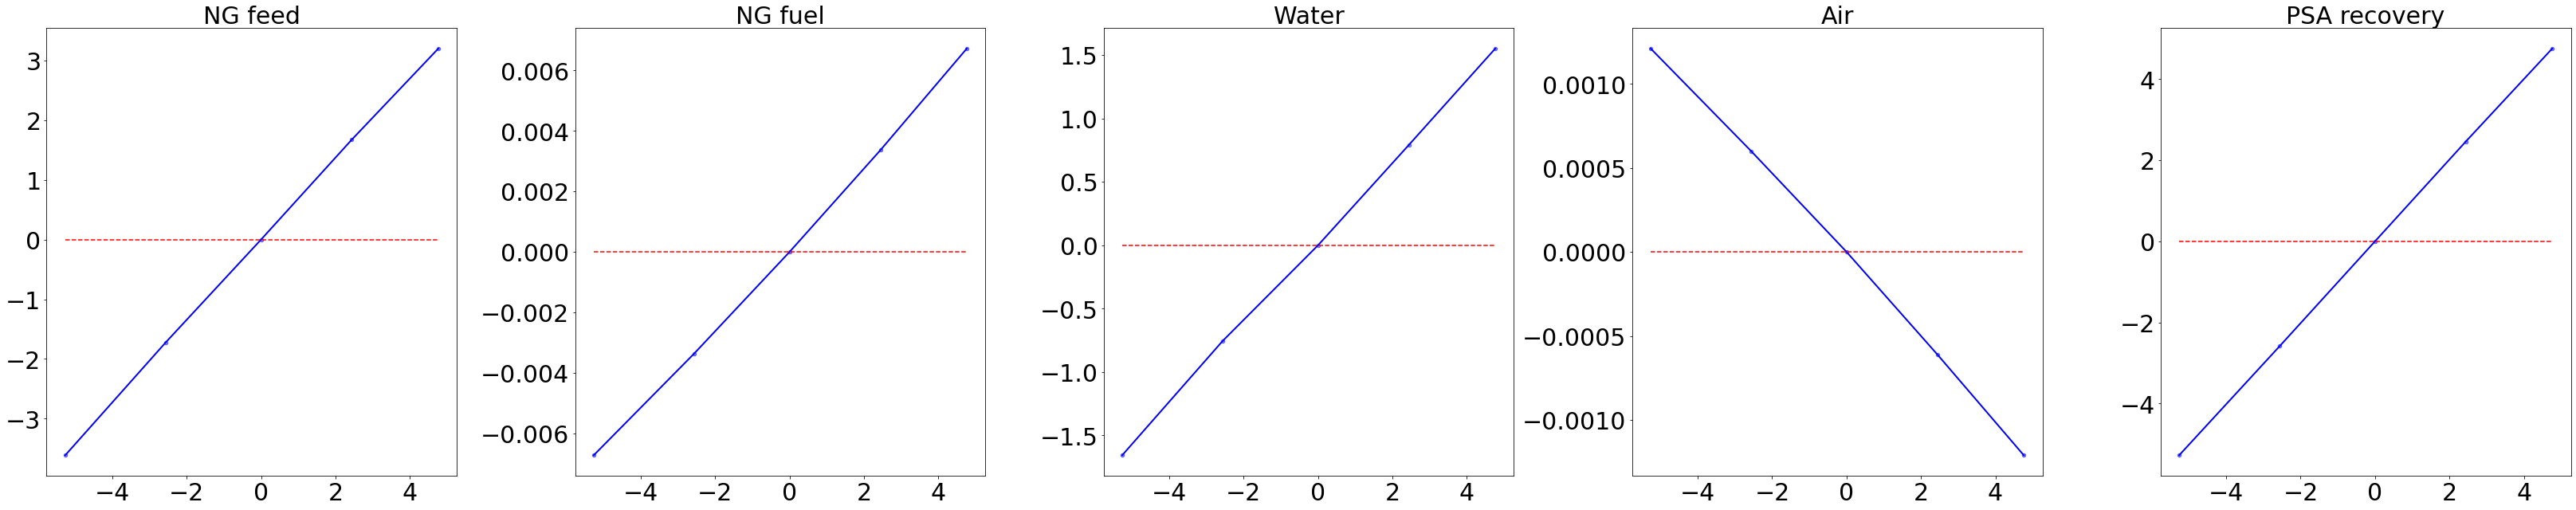

In [90]:
x_base = data_smr[var_x].mean()
sensitivity_points = 5

sensitivity_result = SensitivityAnalysis(x_base, sensitivity_points, nn_model, var_x, var_y, scaler_x, scaler_y)

# 운전조건 최적화 by grid search

In [83]:
def InputCombination(list_input):
    tuple_input = [tuple(input) for input in list_input]
    result = [[]]
    for input in tuple_input:
        result = [x+[y] for x in result for y in input]
    for product in result:
        yield product

def GridSearch(data, bins, nn_model, var_x, var_y, scaler_x, scaler_y):

    x_base = data[var_x].mean()
    x_min = data[var_x].min()
    x_max = data[var_x].max()

    list_input = []
    for i, x in enumerate(x_base.index):
        Input_points = np.linspace(x_min[x], x_max[x], bins, endpoint=True).tolist()
        list_input.append(Input_points)

    x_grid = np.array(
        list(
            InputCombination(
                (x for x in list_input)
                )
            )
        )
    
    print(f"{len(x_grid)} grids are generated\n")
    
    x_grid = pd.DataFrame(x_grid, columns=x_base.index)
    y_grid = scaler_y.inverse_transform(nn_model.predict(scaler_x.transform(x_grid)))

    x_df = pd.DataFrame(x_grid, columns=var_x)
    y_df = pd.DataFrame(y_grid, columns=var_y)
    xy_df = pd.concat([x_df, y_df], axis=1)   

    MW_NG = 17.37               # 17.37 kg/kmol of Natural gas
    MW_H2O = 18.02              # 18.02 kg/kmol of H2O
    MV = 22.4                   # 22.4 Nm3/kmol
    LHV_H2 = 239920
    LHV_NG = 859530
    xy_df['Efficiency'] = (xy_df["H2"]/MV * LHV_H2) / ((xy_df["NG feed"] + xy_df["NG fuel"])/MW_NG * LHV_NG) * 100

    return xy_df

def Optimization(dataframe, var_x, objective_y):
    optimal = dataframe.sort_values(by=objective_y, ascending=False).iloc[0]
    print("Optimal operating condition")
    display(optimal[var_x])
    print()
    print("Optimal value")
    display(optimal[['H2', 'Efficiency']])

In [81]:
data = data_smr
data.describe().loc[['min', 'mean', 'max']]

,NG feed,NG fuel,Water,Air,PSA recovery,H2,Efficiency
min,38.07504,1.192972,128.988119,268.80,71.0,122.000000,63.500000
mean,41.98329,1.314562,141.598690,297.92,78.0,147.247344,74.305312
max,45.89154,1.436152,154.209260,327.04,85.0,175.500000,85.500000


In [82]:
bins = 11

gridsearch_result = GridSearch(data, bins, nn_model, var_x, var_y, scaler_x, scaler_y)

161051 grids are generated



In [84]:
objective_y = "H2"
Optimization(gridsearch_result, var_x, objective_y)

Optimal operating condition


NG feed          45.891540
NG fuel           1.436152
Water           154.209260
Air             327.040000
PSA recovery     85.000000
Name: 161050, dtype: float64


Optimal value


H2            175.471405
Efficiency     80.250592
Name: 161050, dtype: float64

In [85]:
objective_y = "Efficiency"
Optimization(gridsearch_result, var_x, objective_y)

Optimal operating condition


NG feed          38.075040
NG fuel           1.192972
Water           154.209260
Air             268.800000
PSA recovery     85.000000
Name: 1220, dtype: float64


Optimal value


H2            153.888657
Efficiency     84.825204
Name: 1220, dtype: float64